<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Ship Classication Using Transfer Learning<p>

Problem Statement : https://unstop.com/hackathon/lt-edutech-hackathon-at-shaastra-iitm-shaastra-2023-indian-institute-of-technology-iit-madras-579093  
Dataset : https://cutt.ly/PS_3_dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,classification_report

import os
import glob
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.xception import preprocess_input,Xception

import warnings
warnings.filterwarnings("ignore")

# strategy = tf.distribute.MirroredStrategy()
# print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

FILE_DIR='/kaggle/input/game-of-deep-learning-ship-datasets/train/images'

In [2]:
submission=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv')
test=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
train=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')

For Reference : `{0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}`

In [3]:
d={}

for i in glob.glob(FILE_DIR+'/*.jpg'):
    img=cv2.imread(i)
    resulting_img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    final_image=tf.keras.applications.xception.preprocess_input(resulting_img)
    d[os.path.basename(i)]=final_image

In [4]:
train_img_list=list(train.image)
test_img_list=list(test.image)

In [5]:
train_dic={k: d[k] for k in train_img_list} 
test_dic={k: d[k] for k in test_img_list} 

In [6]:
model_inputs=np.array(list(train_dic.values()))

In [7]:
train_labels=np.array(list(train.category))-1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs,train_labels, test_size=0.1, random_state=42)

In [9]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
base_model=Xception(weights="imagenet",include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5,activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input,outputs=output)

2023-01-17 16:11:10.320009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:11:10.320936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:11:10.458397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:11:10.459355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:11:10.460165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [11]:
for layer in base_model.layers:
    layer.trainable=False
# with tpu_strategy.scope():
optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])


# with strategy.scope():
history = model.fit(x=model_inputs,y=train_labels,epochs=5,validation_data=(X_val,y_val))

2023-01-17 16:11:15.482671: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.
2023-01-17 16:11:16.978807: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.
2023-01-17 16:11:18.007933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-01-17 16:11:21.744515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


196/196 [==============================] - 23s 61ms/step - loss: 8.3232 - accuracy: 0.6715 - val_loss: 2.6827 - val_accuracy: 0.7842
Epoch 2/5
196/196 [==============================] - 10s 51ms/step - loss: 3.3555 - accuracy: 0.7641 - val_loss: 1.6592 - val_accuracy: 0.8233
Epoch 3/5
196/196 [==============================] - 10s 52ms/step - loss: 2.2932 - accuracy: 0.7892 - val_loss: 1.4926 - val_accuracy: 0.8295
Epoch 4/5
196/196 [==============================] - 10s 53ms/step - loss: 1.3348 - accuracy: 0.8210 - val_loss: 0.9368 - val_accuracy: 0.8641
Epoch 5/5
196/196 [==============================] - 10s 53ms/step - loss: 0.9818 - accuracy: 0.8487 - val_loss: 0.6943 - val_accuracy: 0.8641


In [12]:
for layer in base_model.layers:
    layer.trainable=True
# with tpu_strategy.scope():
optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

history = model.fit(x=model_inputs,y=train_labels,epochs=25,validation_data=(X_val,y_val))

2023-01-17 16:12:42.456883: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.
2023-01-17 16:12:43.940885: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.


Epoch 1/15
196/196 [==============================] - 46s 207ms/step - loss: 1.5413 - accuracy: 0.3375 - val_loss: 2.9555 - val_accuracy: 0.2149
Epoch 2/15
196/196 [==============================] - 38s 196ms/step - loss: 1.4497 - accuracy: 0.3661 - val_loss: 1.5706 - val_accuracy: 0.3330
Epoch 3/15
196/196 [==============================] - 38s 196ms/step - loss: 1.3499 - accuracy: 0.4047 - val_loss: 1.3150 - val_accuracy: 0.4272
Epoch 4/15
196/196 [==============================] - 38s 196ms/step - loss: 1.2713 - accuracy: 0.4469 - val_loss: 1.2835 - val_accuracy: 0.4947
Epoch 5/15
196/196 [==============================] - 38s 195ms/step - loss: 1.0648 - accuracy: 0.5523 - val_loss: 1.0244 - val_accuracy: 0.5782
Epoch 6/15
196/196 [==============================] - 39s 197ms/step - loss: 0.9137 - accuracy: 0.6257 - val_loss: 0.8918 - val_accuracy: 0.6616
Epoch 7/15
196/196 [==============================] - 38s 195ms/step - loss: 0.7954 - accuracy: 0.6799 - val_loss: 0.7632 - val_ac

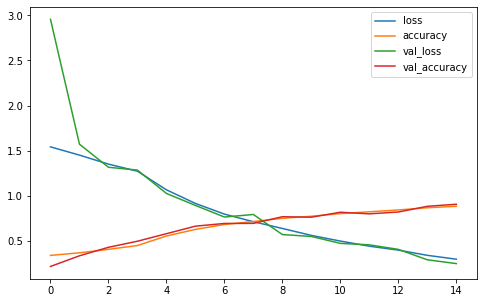

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [14]:
y_pred_ = model.predict(X_test)
y_pred = np.argmax(y_pred_,axis=1)

In [15]:
print(f"Classifiction Report :\n {classification_report(y_test,y_pred)}")

Classifiction Report :
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       201
           1       0.96      0.90      0.93       112
           2       0.98      0.97      0.97        95
           3       0.81      1.00      0.90        82
           4       0.87      0.85      0.86       136

    accuracy                           0.91       626
   macro avg       0.91      0.92      0.91       626
weighted avg       0.91      0.91      0.91       626



<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Judging Metric : Kappa Score<p> 

In [16]:
kappa_scr=cohen_kappa_score(y_pred,y_test)
print(f"Kappa Score : {kappa_scr}")

Kappa Score : 0.8813805180209613


### Predicting Values for given test dataset

In [21]:
test_model_inputs=np.array(list(test_dic.values()))

In [22]:
output_labels = model.predict(test_model_inputs)

In [32]:
output_labels_ind = np.argmax(output_labels,axis=1)+1

In [34]:
np.bincount(output_labels_ind)

array([  0, 893, 484, 346, 420, 537])

In [35]:
submission['category']=output_labels_ind

In [37]:
submission.to_csv('submission.csv',index=False)

<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Optimal Training dataset size<p> 

In [ ]:
split_size_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
kappa_score=[]

In [ ]:
for i in split_size_list:    
    X_train, X_test, y_train, y_test = train_test_split(model_inputs,train_labels, test_size=i, random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    base_model=Xception(weights="imagenet",include_top=False)
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(5,activation='softmax')(avg)
    model = tf.keras.Model(inputs=base_model.input,outputs=output)
    for layer in base_model.layers:
        layer.trainable=False
    # with tpu_strategy.scope():
    optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])


    # with strategy.scope():
    history = model.fit(x=model_inputs,y=train_labels,epochs=5,validation_data=(X_val,y_val))

    for layer in base_model.layers:
    layer.trainable=True
    # with tpu_strategy.scope():
    optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

    history = model.fit(x=model_inputs,y=train_labels,epochs=25,validation_data=(X_val,y_val))

    y_pred_ = model.predict(X_test)
    y_pred = np.argmax(y_pred_,axis=1)

    kappa_score.append(cohen_kappa_score(y_pred,y_test))

In [ ]:
plt.plot(np.array(split_size_list)*100,np.array(kappa_score))
plt.xlabel("Training Data %")
plt.ylabel("Metric - Kappa Score")
plt.show()

- Best/Optimal Training Data percentage is when the model attain the highest kappa score i.e(~ 0.9-1).